In [428]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import math
from datetime import datetime
from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

#!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_store = pd.read_csv("C:/Users/aryan/Downloads/archive (1)/stores.csv")

In [5]:
df_features = pd.read_csv("C:/Users/aryan/Downloads/archive (1)/features.csv")

In [7]:
df_train = pd.read_csv("C:/Users/aryan/Downloads/archive (1)/train.csv")

In [9]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [15]:
df = df_train.merge(df_features, on = ['Store', 'Date'], how = 'inner').merge(df_store, on = ['Store'], how = 'inner')

In [17]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [19]:
df.drop(['IsHoliday_y'], axis = 1, inplace = True)

In [21]:
df.rename(columns = {"IsHoliday_x":"IsHoliday"}, inplace = True)

In [23]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [25]:
df.shape

(421570, 16)

In [27]:
df['Store'].nunique()

45

In [29]:
df['Dept'].nunique()

81

There are 45 different stores and 81 different departments.

In [32]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept', 
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

C:\Users\aryan\AppData\Local\Temp\ipykernel_23232\2681735725.py:1: FutureWarning: The provided callable <function mean at 0x000001AB201463E0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',


Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


In [34]:
df.groupby(['Store', 'Dept'])['Weekly_Sales'].mean().reset_index()

,Store,Dept,Weekly_Sales
0,1,1,22513.322937
1,1,2,46102.090420
2,1,3,13150.478042
3,1,4,36964.154476
4,1,5,24257.941119
...,...,...,...
3326,45,94,3690.272090
3327,45,95,52896.166643
3328,45,96,2.970000
3329,45,97,6466.961888


In [36]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


There are total of 421570 rows in which 1358 rows are either zero or negative. This makes 0.3% of the rows negative/zero. We can drop these rows to get the dataframe with correct values.

In [39]:
df = df.loc[df['Weekly_Sales']>0]

In [41]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221


Now we will look at the Holidays in the dataset.

Now that we have the correct dataset, we can start working on it.

In [45]:
pd.concat([df['Date'].head(5), df['Date'].tail(5)])

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

The date starts from 5th Feb 2010 to 26th October 2012

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

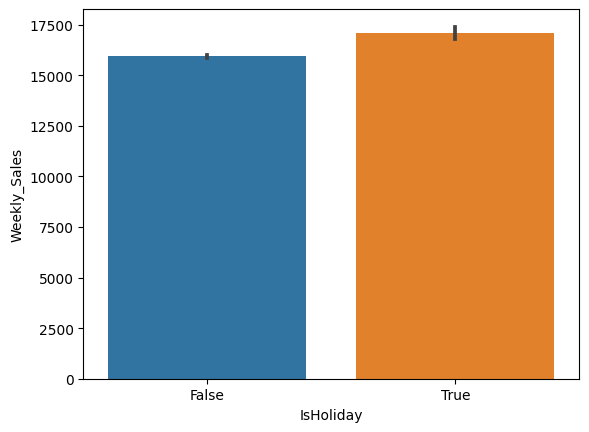

In [48]:
sns.barplot(x = 'IsHoliday', y = 'Weekly_Sales', data = df)

In [50]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [52]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

133

Here we have used unique() for Holidays as there are few dates, and nunique() for not holidays as there are many dates and we dont want the array, we just want the number of dates.

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [56]:
#Taking all the Super Bowl Dates
df['Super_Bowl'] = df['Date'].isin(['2010-02-12', '2011-02-11', '2012-02-12'])

In [58]:
#Taking all the Labor Days Dates
df['Labor_Day'] = df['Date'].isin(['2010-09-10', '2011-09-10', '2012-09-07'])

In [60]:
#Taking all the Thanksgiving Dates
df['Thanksgiving'] = df['Date'].isin(['2010-11-26', '2011-11-25', '2012-11-23'])

In [62]:
#Taking all the Christmas Dates
df['Christmas'] = df['Date'].isin(['2010-12-31', '2011-12-30', '2012-12-28'])

In [64]:
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,False,False,False,False
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,False,False,False,False
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,False,False,False,False
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,False,False,False,False
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,False,False,False,False


<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

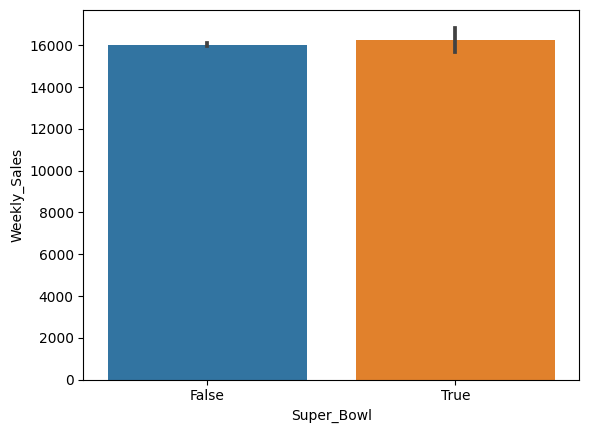

In [66]:
sns.barplot(x = 'Super_Bowl', y = 'Weekly_Sales', data = df)

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

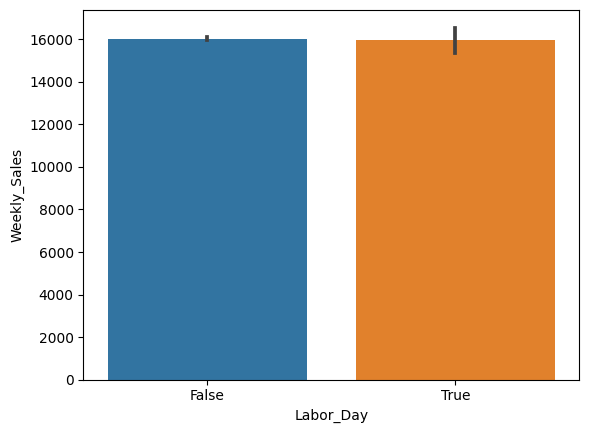

In [68]:
sns.barplot(x = 'Labor_Day', y = 'Weekly_Sales', data = df)

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

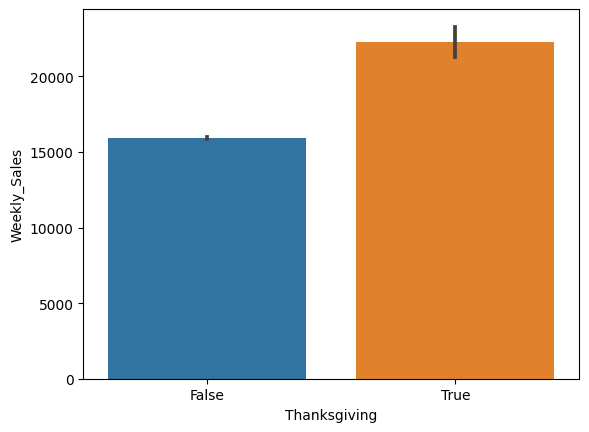

In [70]:
sns.barplot(x = 'Thanksgiving', y = 'Weekly_Sales', data = df)

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

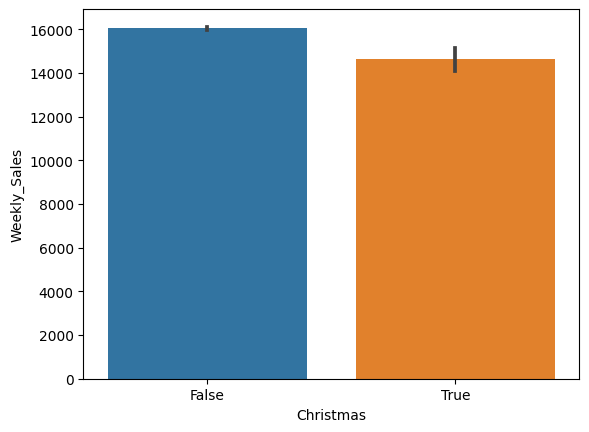

In [72]:
sns.barplot(x = 'Christmas', y = 'Weekly_Sales', data = df)

Here we see that the sales on Christmas and Labor Day does not increase the average sales. Super Bowl and Thanksgiving have an increase in the average sales. Thanksgiving has an increase because of the Black Friday sales. People buy christmas gift a week or two in advance, during the Thanksgiving sale.

In [75]:
df.groupby(['Super_Bowl', 'Type'])['Weekly_Sales'].mean()

Super_Bowl  Type
False       A       20144.507137
            B       12289.697797
            C        9540.026119
True        A       20401.250063
            B       12350.174708
            C       10239.943409
Name: Weekly_Sales, dtype: float64

In [77]:
df.groupby(['Labor_Day', 'Type'])['Weekly_Sales'].mean()

Labor_Day  Type
False      A       20149.353858
           B       12293.264327
           C        9542.417249
True       A       20060.598111
           B       12098.648882
           C       10045.474040
Name: Weekly_Sales, dtype: float64

In [79]:
df.groupby(['Thanksgiving', 'Type'])['Weekly_Sales'].mean()

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [81]:
df.groupby(['Christmas', 'Type'])['Weekly_Sales'].mean()

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [83]:
store_counts = df['Type'].value_counts()  # Count occurrences of each store type
total_stores = store_counts.sum()  # Total number of stores

# Calculate percentages
store_percentages = (store_counts / total_stores) * 100

print(store_percentages)

Type
A    51.155369
B    38.739255
C    10.105375
Name: count, dtype: float64


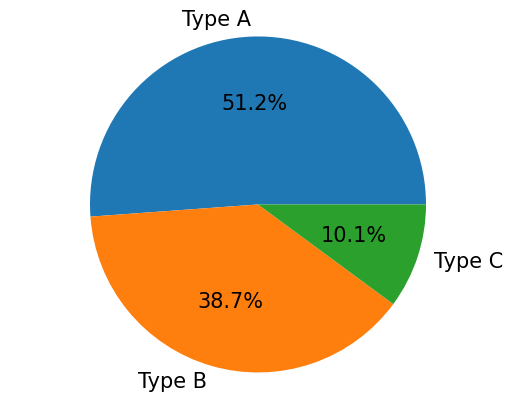

In [85]:
my_data = store_percentages  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

More than half of the stores belongs to Type A.

In [88]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

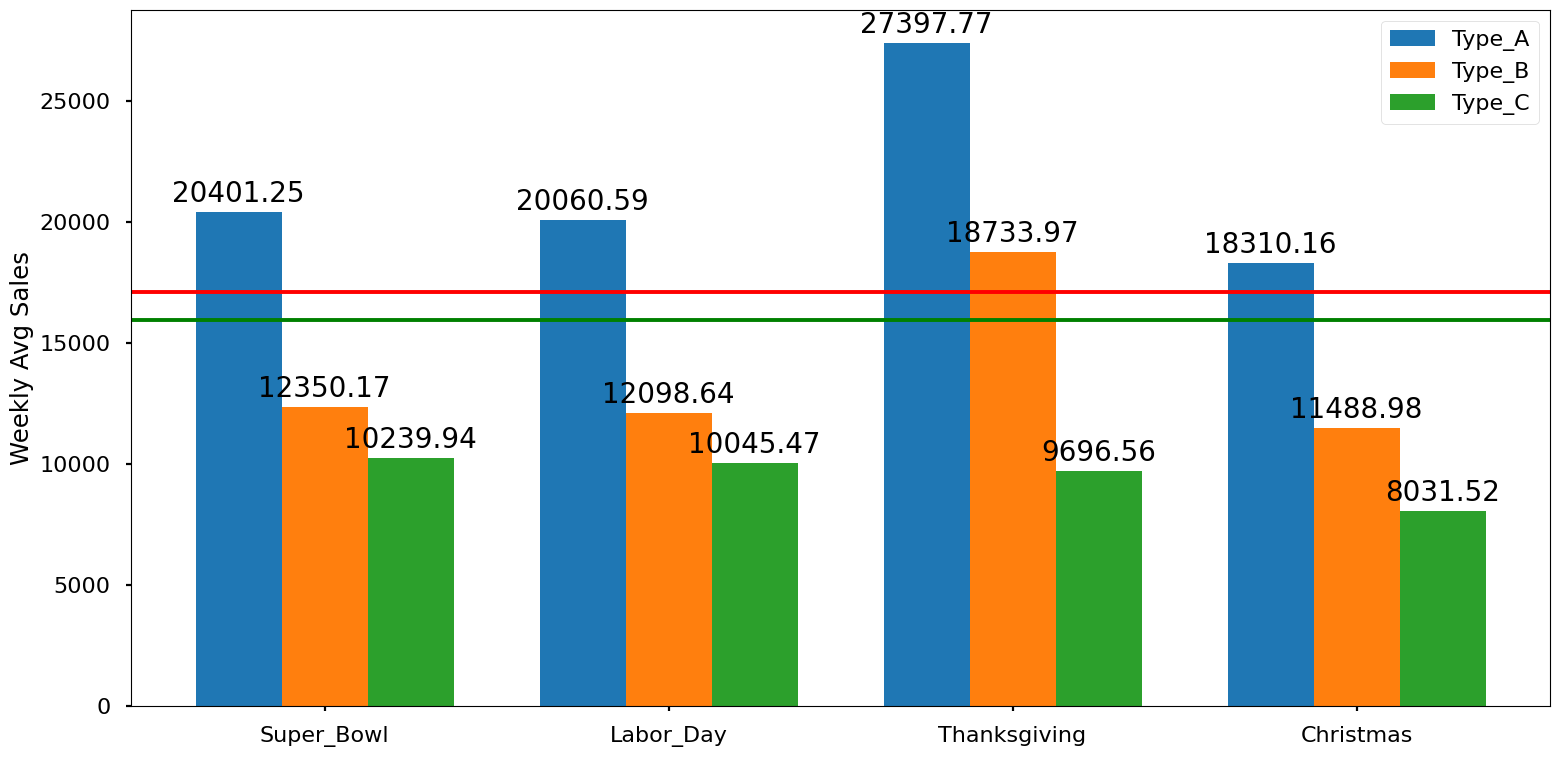

In [96]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-v0_8-poster')
labels = ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']
A_means = [20401.25, 20060.59, 27397.77, 18310.16]
B_means = [12350.17, 12098.64, 18733.97, 11488.98]
C_means = [10239.94,10045.47,9696.56,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.81,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

The highest sales were in Thanksgiving. The highest sales among all the stores were from the Type A stores.

In [99]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


All the top 5 sales were from Thannksgiving holidays.

SIZE_TYPE RELATION

In [104]:
df_store.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


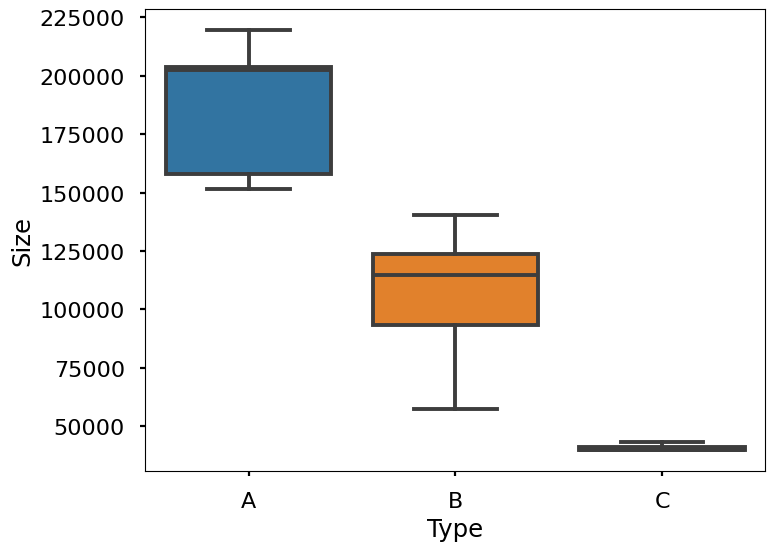

In [108]:
plt.figure(figsize=(8,6)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Here we can see that, higher the number of stores, higher is the sales. The smallest size of Type A store, the Type B store begins and same for the Type C store. The smallest size of Type B store, the Type C store starts.

MARKDOWN SALES

In [112]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [114]:
df = df.fillna(0)

In [116]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [118]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


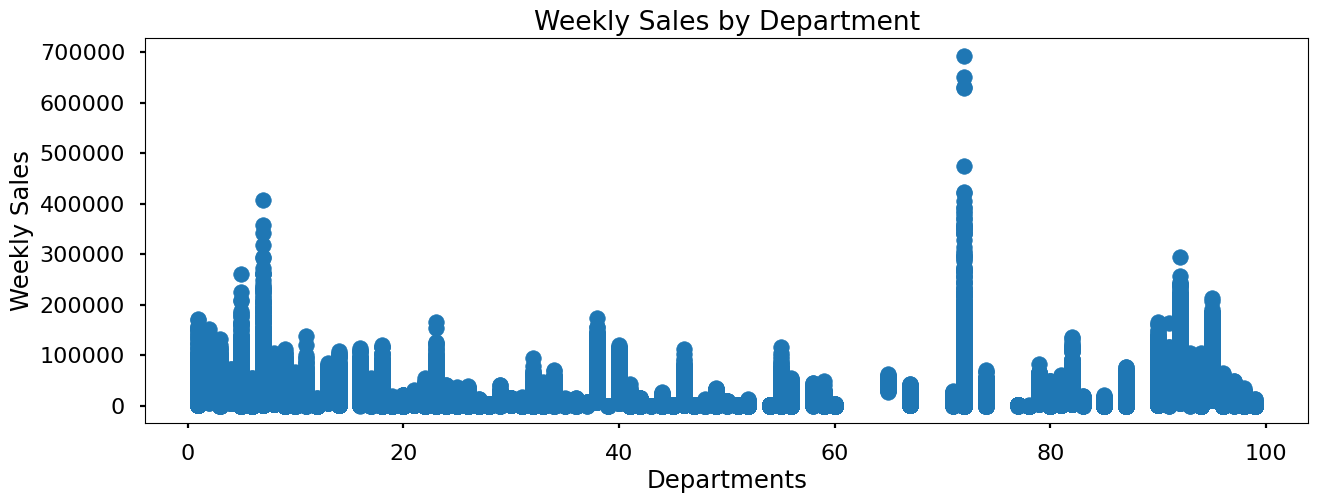

In [120]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

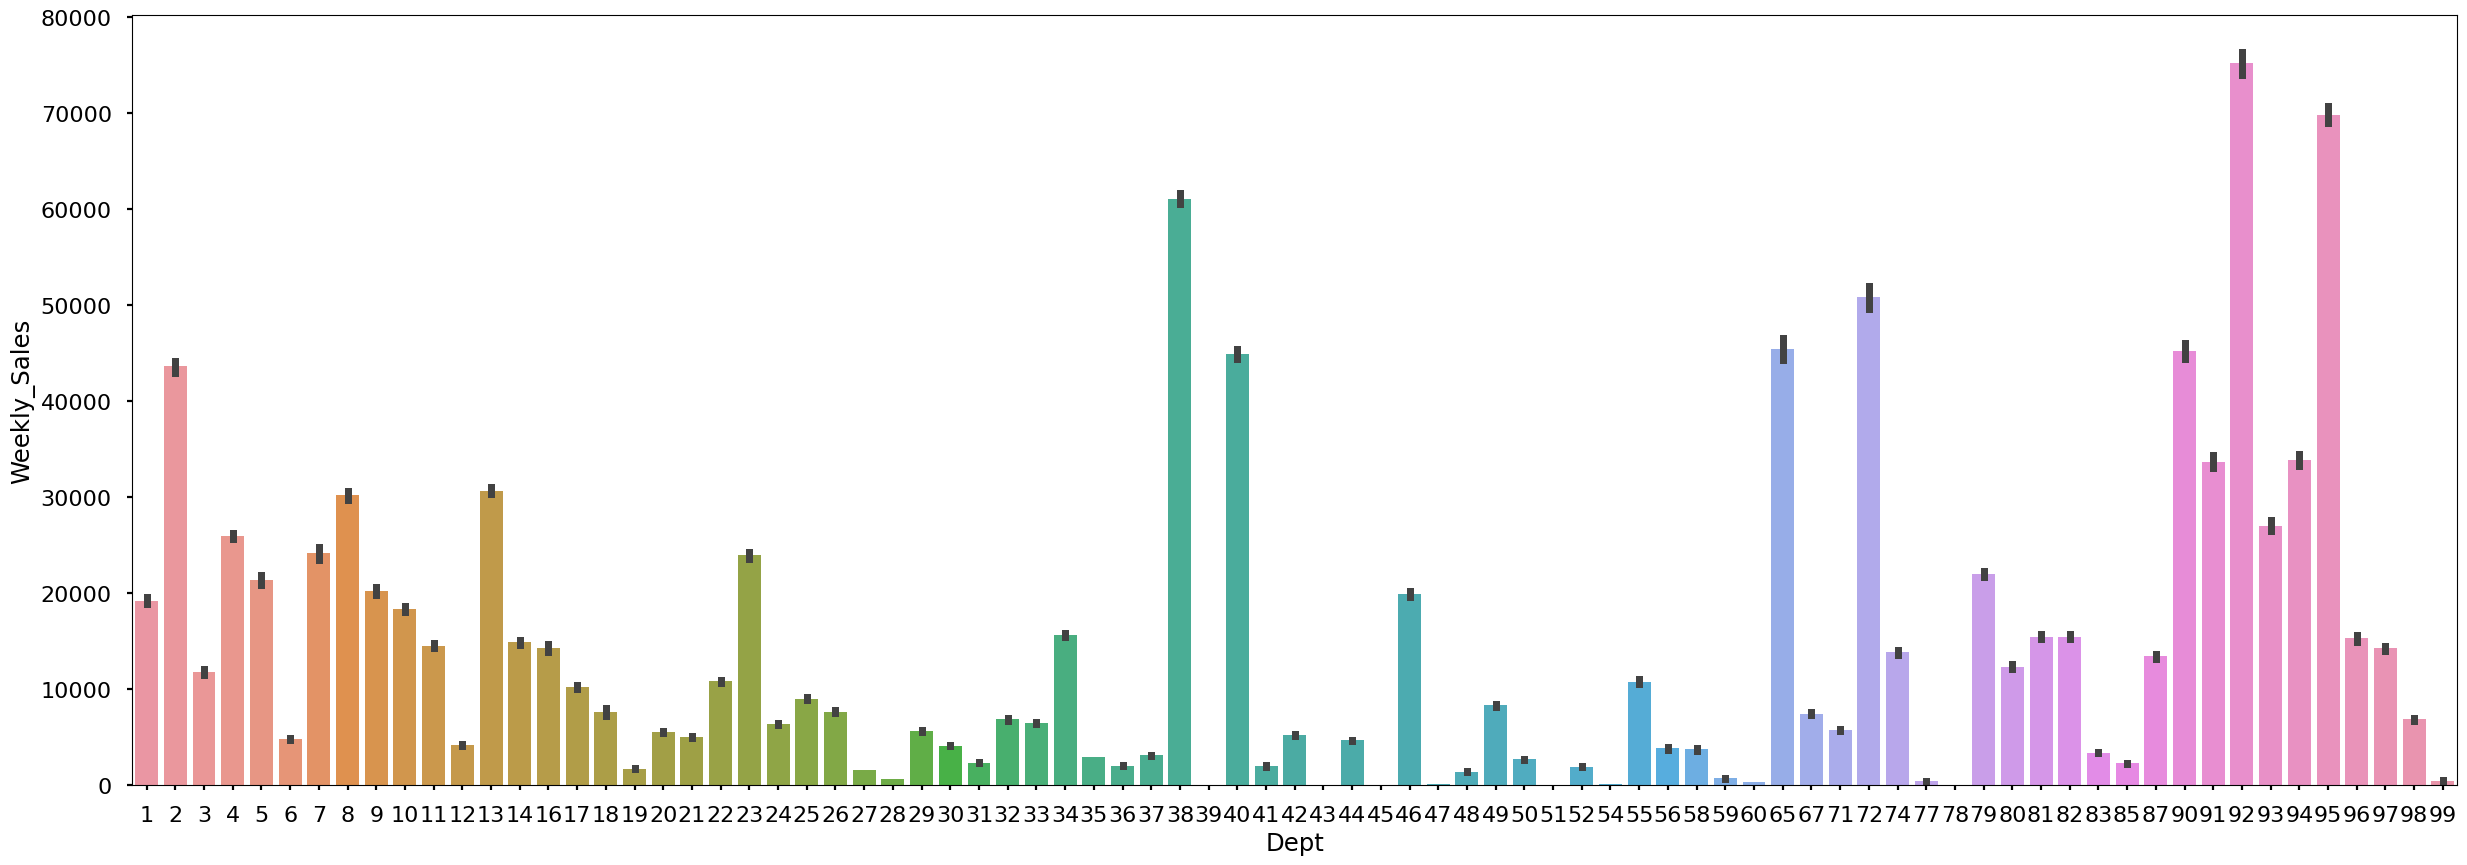

In [122]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

From graph 1, we see that one department between 60-80 has the higher sales values. This might be a seasonal department as when we check the graph 2 (average sales), we see that department 92 has higher weekly sales.

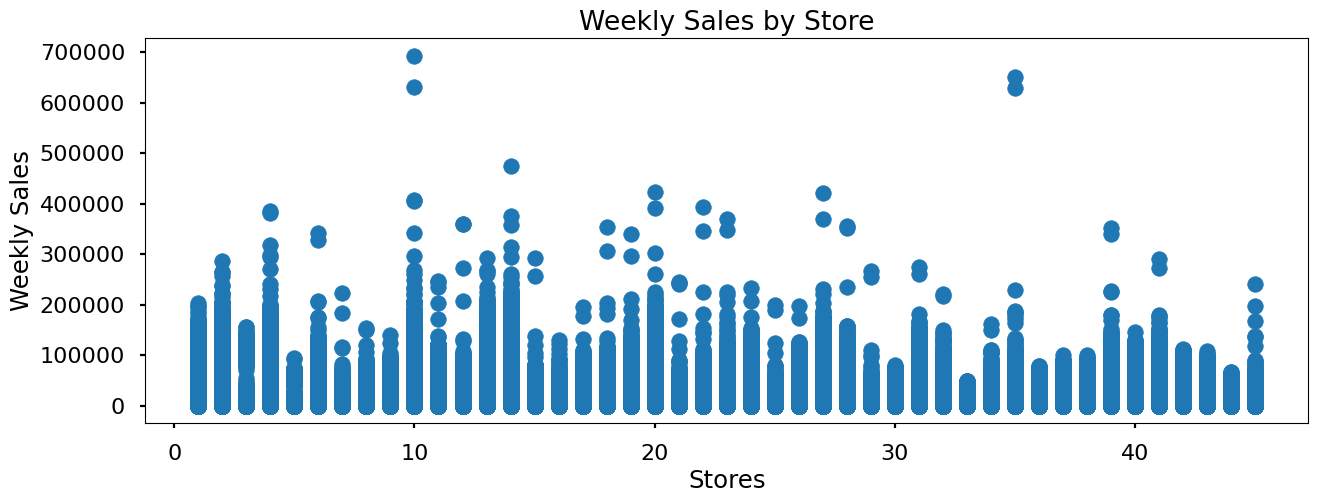

In [125]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

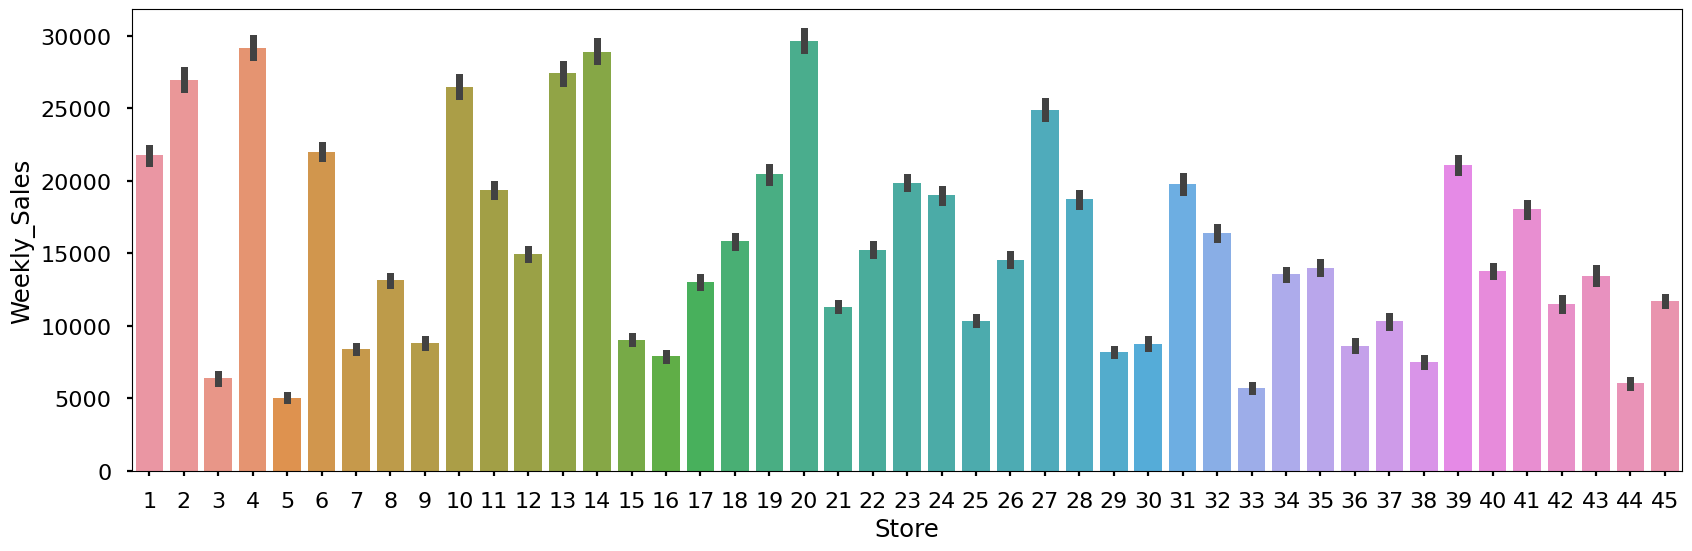

In [127]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

In the above two graphs, from graph 1, we see that store 10 has the higher value sales and from graph 2 we see that store 4 and store 20 have higher average sales. Store 20, 4 have best sales followed by store 14.

In [134]:
df["Date"] = pd.to_datetime(df["Date"])  # convert to datetime
df['week'] = df['Date'].dt.isocalendar().week  # get ISO week
df['month'] = df['Date'].dt.month  # get month
df['year'] = df['Date'].dt.year  # get year

In [136]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012


In [138]:
df.groupby('month')['Weekly_Sales'].mean()

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [140]:
df.groupby('year')['Weekly_Sales'].mean()

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

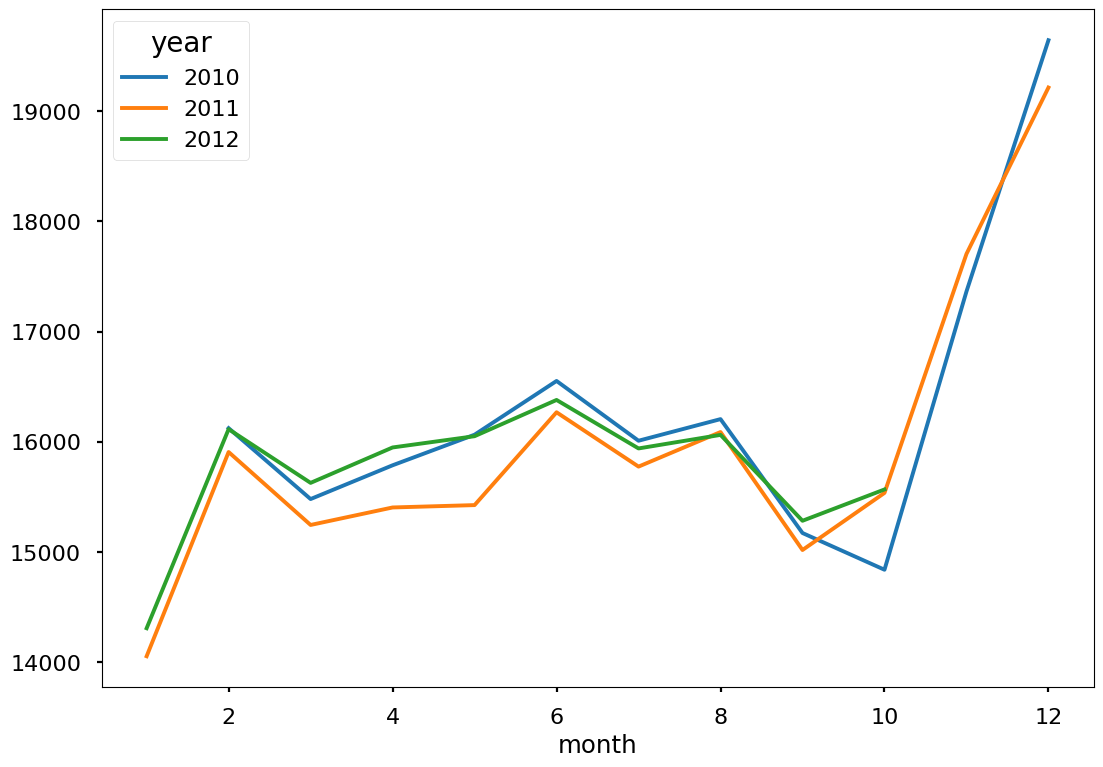

In [142]:
monthly_sales = pd.pivot_table(df, values = 'Weekly_Sales', columns = 'year', index = 'month')
monthly_sales.plot()

In general, 2011 has lesser sales than 2012. Every year, November and December had the highest sale. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

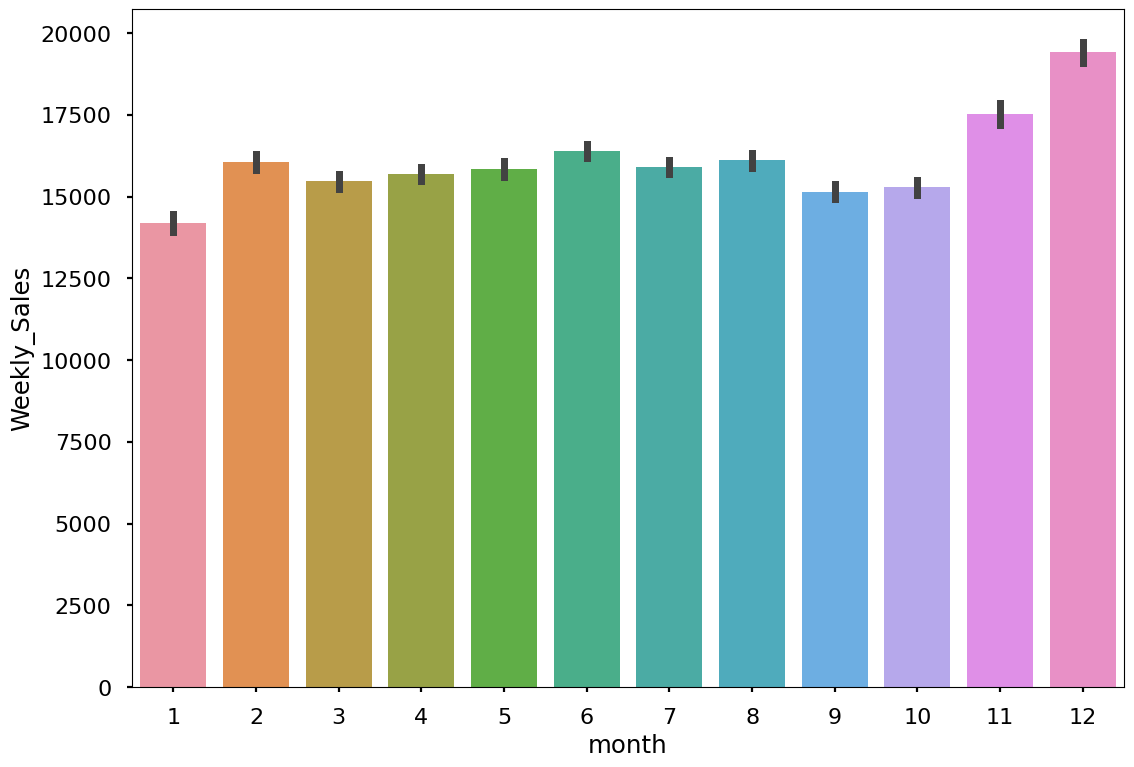

In [145]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [148]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed.

<Axes: xlabel='week'>

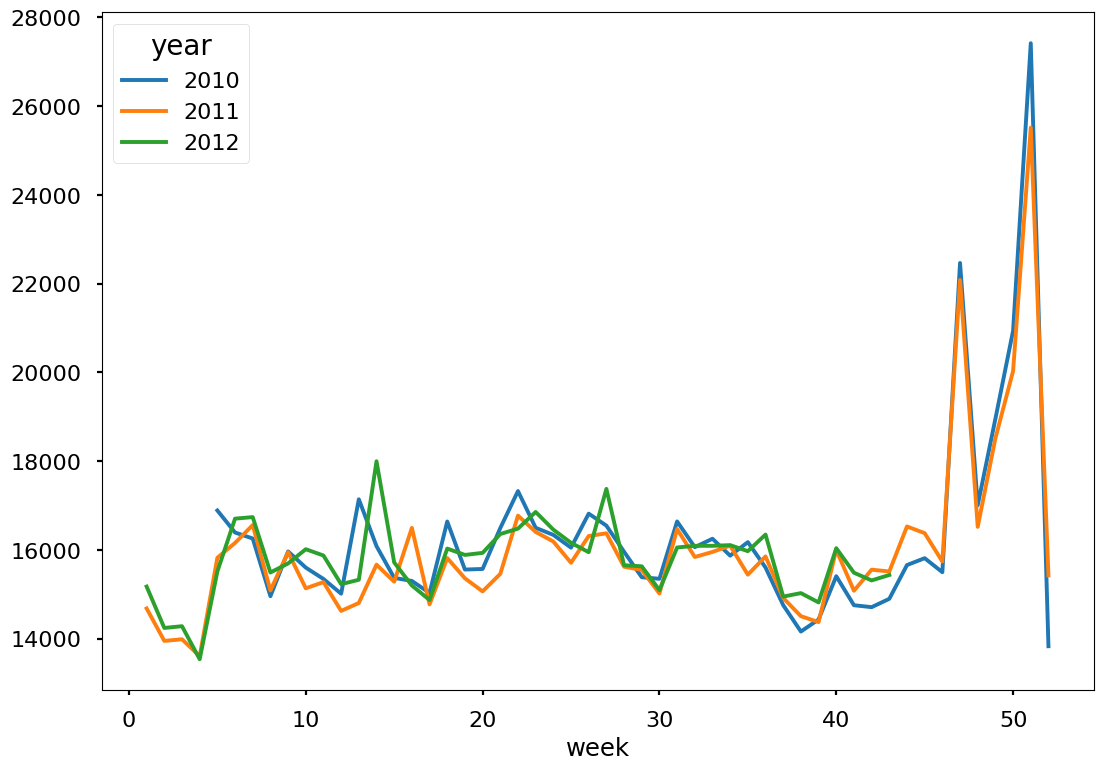

In [151]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

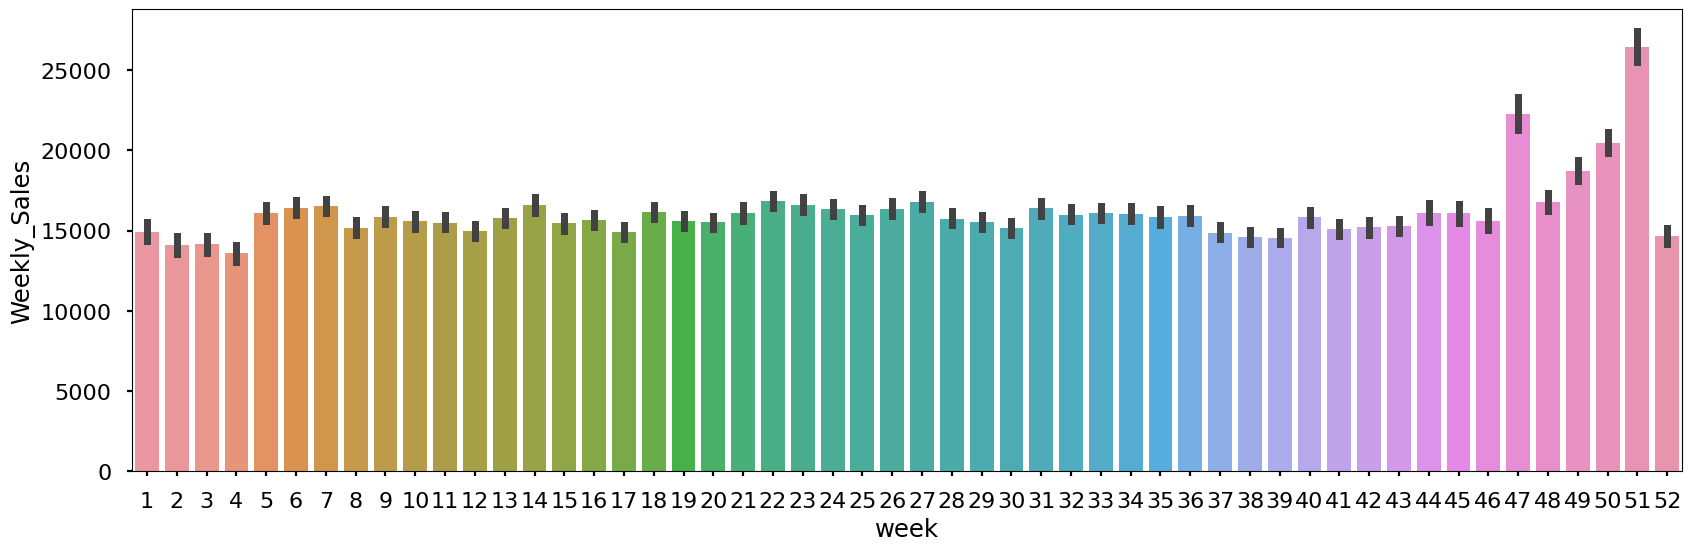

In [153]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

The best sales were in week 51 and week 47. These are the weeks before christmas and Thanksgiving/Black Friday.

Fuel Price, CPI , Unemployment , Temperature Effects

<Axes: xlabel='Fuel_Price'>

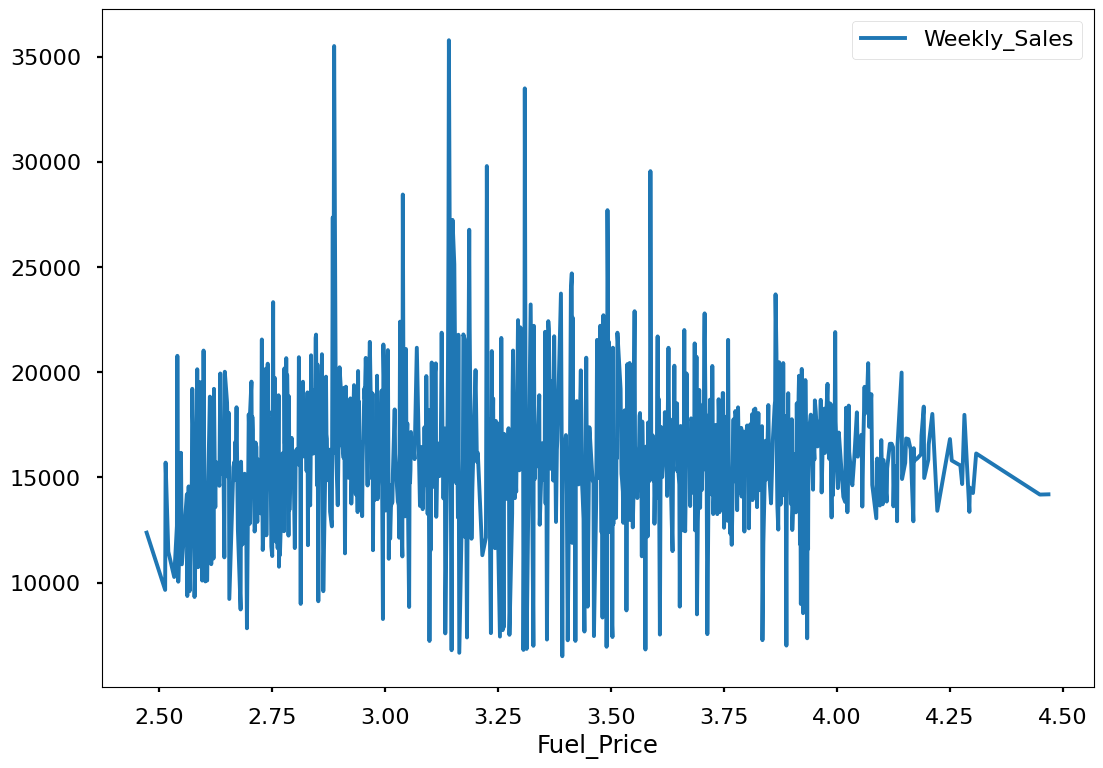

In [158]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

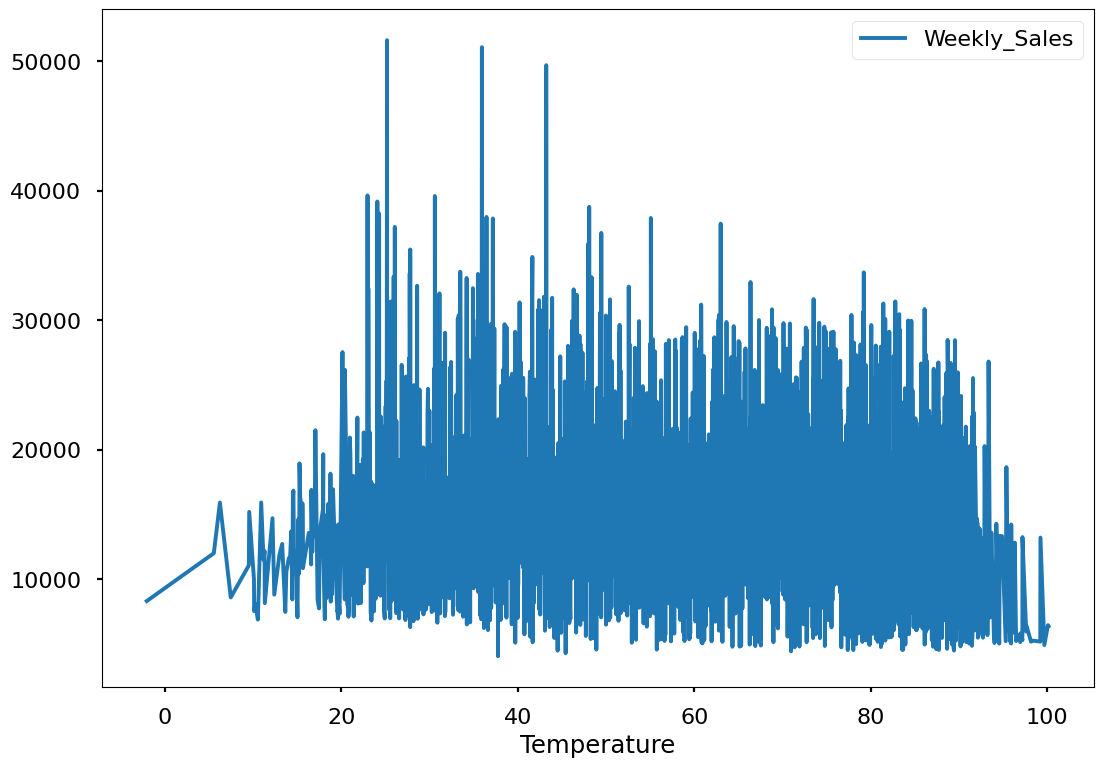

In [160]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

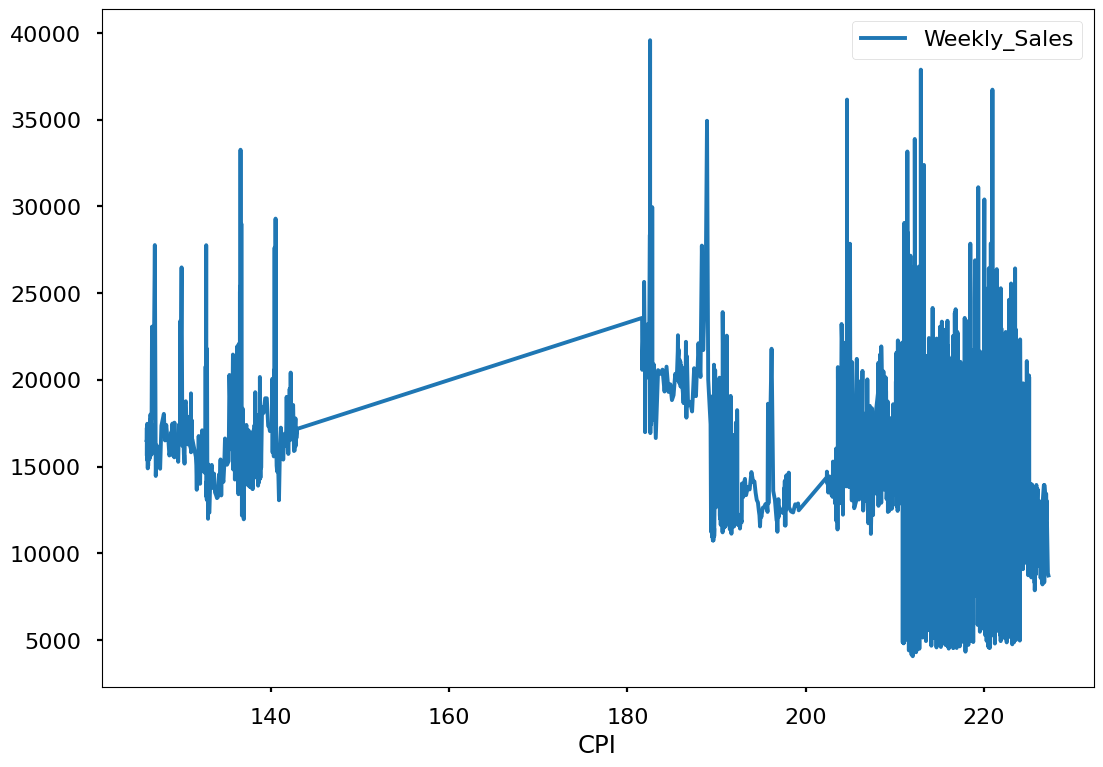

In [162]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

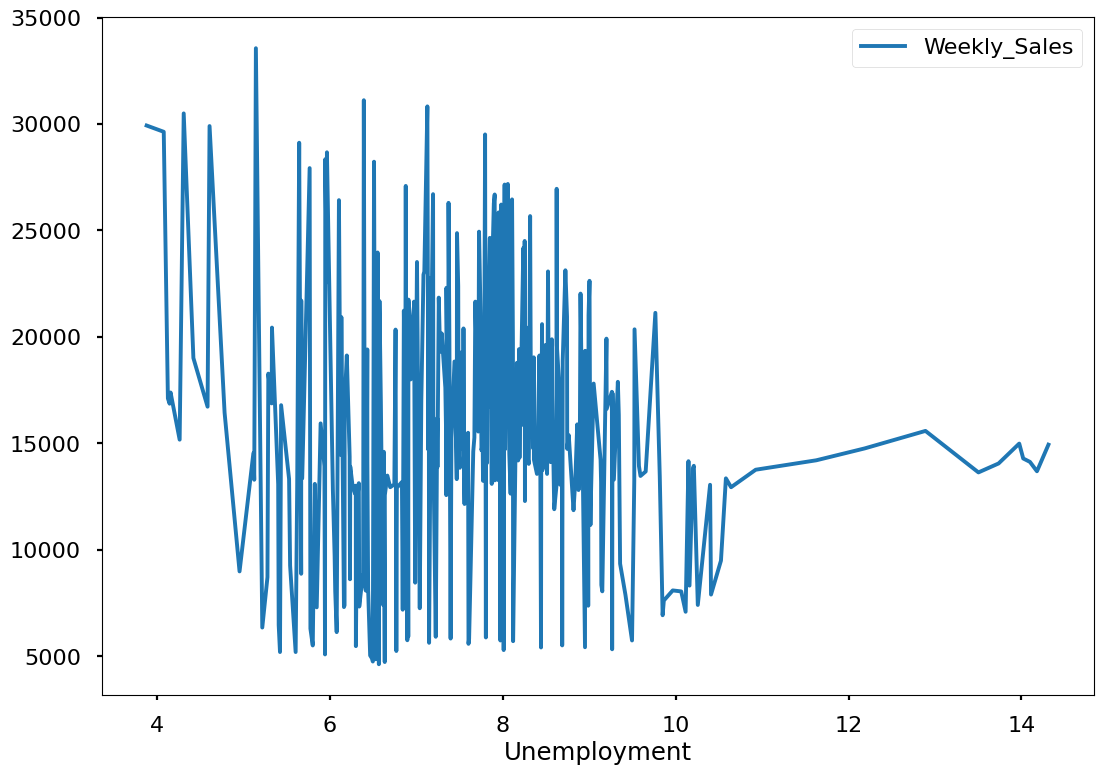

In [164]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

In [167]:
df.to_csv('clean_data.csv')

- There are 45 stores and 81 department in data. Departments are not same in all stores.
Although department 72 has higher weekly sales values, on average department 92 is the best. It shows us, some departments has higher values as seasonal like Thanksgiving. It is consistant when we look at the top 5 sales in data, all of them belongs to 72th department at Thanksgiving holiday time.
- Although stores 10 and 35 have higher weekly sales values sometimes, in general average store 20 and store 4 are on the first and second rank. It means that some areas has higher seasonal sales.
- Stores has 3 types as A, B and C according to their sizes. Almost half of the stores are bigger than 150000 and categorized as A. According to type, sales of the stores are changing.
- As expected, holiday average sales are higher than normal dates.
- Christmas holiday introduces as the last days of the year. But people generally shop at 51th week. So, when we look at the total sales of holidays, Thankgiving has higher sales between them which was assigned by Walmart.
- Year 2010 has higher sales than 2011 and 2012. But, November and December sales are not in the data for 2012. Even without highest sale months, 2012 is not significantly less than 2010, so after adding last two months, it can be first.
- It is obviously seen that week 51 and 47 have higher values and 50-48 weeks follow them. Interestingly, 5th top sales belongs to 22th week of the year. This results show that Christmas, Thankgiving and Black Friday are very important than other weeks for sales and 5th important time is 22th week of the year and it is end of the May, when schools are closed. Most probably, people are preparing for holiday at the end of the May.
- January sales are significantly less than other months. This is the result of November and December high sales. After two high sales month, people prefer to pay less on January.
- CPI, temperature, unemployment rate and fuel price have no pattern on weekly sales.

Generally, Rondom Forest Regressor gives good results when we tune it well. So, to find simple baseline model, I will use RandomForestRegressor in this notebook.

In [179]:
pd.options.display.max_columns=100 # to see columns

In [181]:
df = pd.read_csv('C:/Users/aryan/Desktop/clean_data.csv')

In [183]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [185]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

In [187]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420207,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False,False,False,False,43,10,2012
420208,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False,False,False,False,43,10,2012
420209,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False,False,False,False,43,10,2012
420210,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False,False,False,False,43,10,2012


For preprocessing our data, I will change holidays boolean values to 0-1 and replace type of the stores from A, B, C to 1, 2, 3.

In [190]:
df_encoded = df.copy()

In [192]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [194]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [196]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

Firstly, I will drop the holiday columns (Christmas, Thanksgiving, Labor_Day and Super_Bowl) from my data and try without them. To keep my encoded data safe, I assigned my dataframe to new one and I will use for this.

In [199]:
drop_column = ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']
df_new.drop(drop_column, axis = 1, inplace = True)

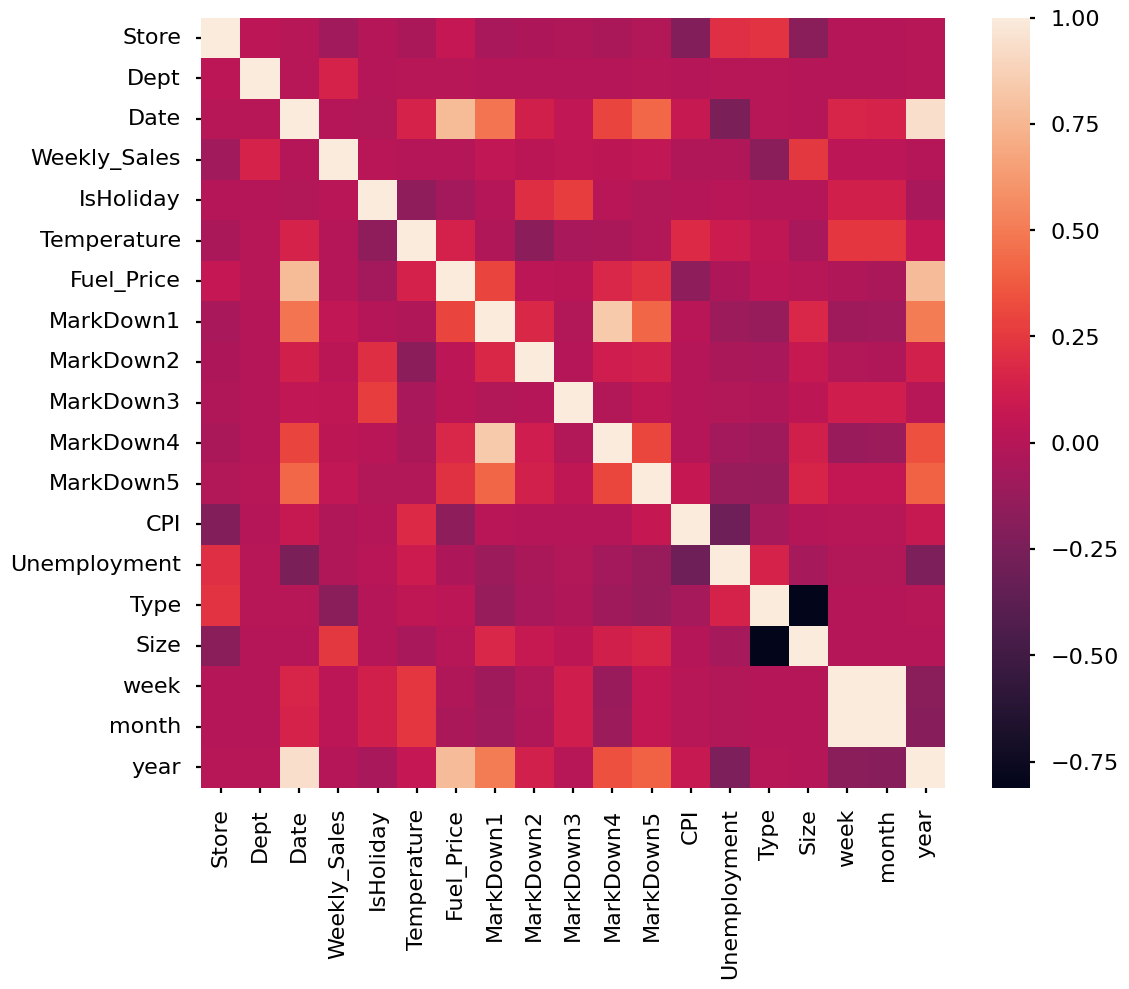

In [201]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr())
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

In [204]:
drop_column = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_column, axis=1, inplace=True) # dropping columns

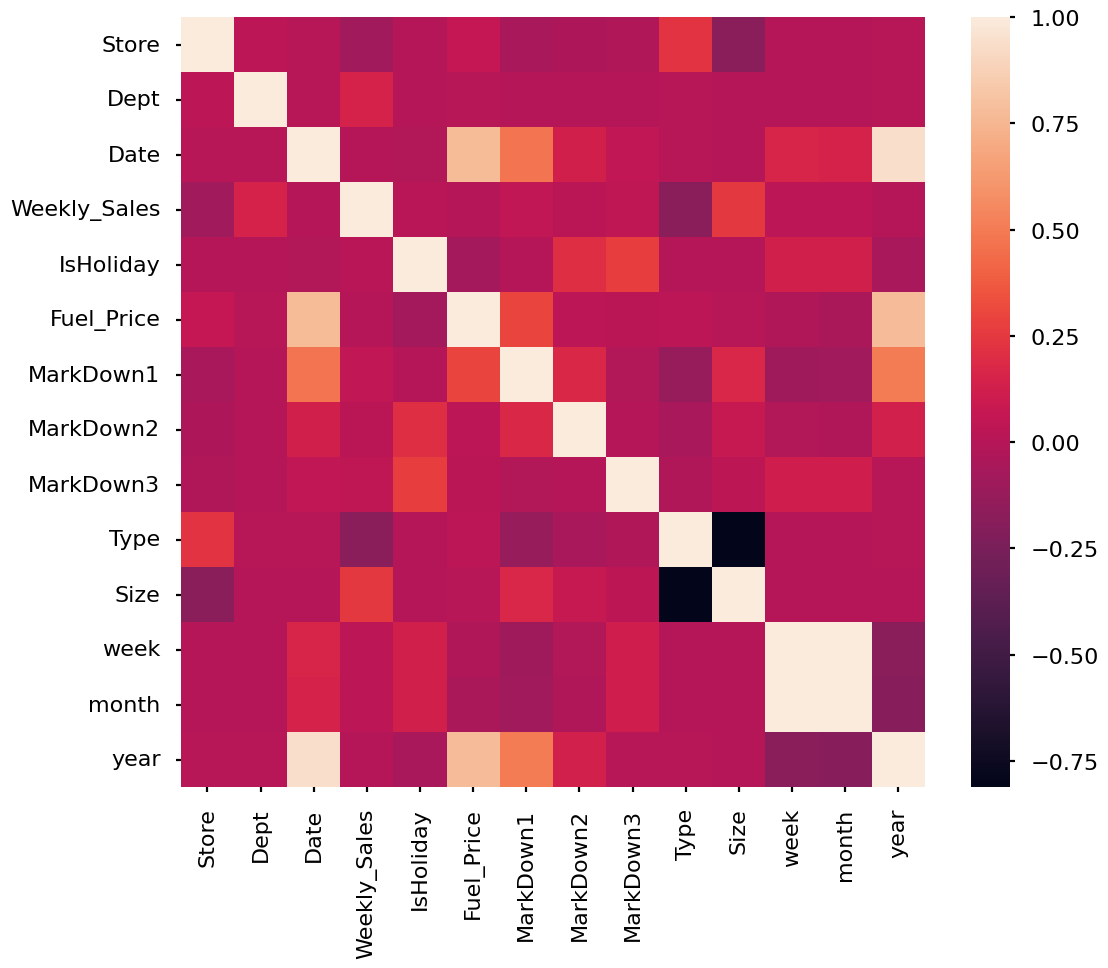

In [208]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr())
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [213]:
df_new = df_new.sort_values(by = 'Date', ascending = True)

In [215]:
df_new

,Store,Dept,Date,Weekly_Sales,IsHoliday,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,Type,Size,week,month,year
0,1,1,2010-02-05,24924.50,0,2.572,0.00,0.00,0.0,1,151315,5,2,2010
329781,35,3,2010-02-05,14612.19,0,2.784,0.00,0.00,0.0,2,103681,5,2,2010
329782,35,4,2010-02-05,26323.15,0,2.784,0.00,0.00,0.0,2,103681,5,2,2010
329783,35,5,2010-02-05,36414.63,0,2.784,0.00,0.00,0.0,2,103681,5,2,2010
329784,35,6,2010-02-05,11437.81,0,2.784,0.00,0.00,0.0,2,103681,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329722,34,14,2012-10-26,8930.71,0,3.514,1151.88,68.01,3.0,1,158114,43,10,2012
329723,34,16,2012-10-26,4841.81,0,3.514,1151.88,68.01,3.0,1,158114,43,10,2012
329724,34,17,2012-10-26,7035.13,0,3.514,1151.88,68.01,3.0,1,158114,43,10,2012
329726,34,20,2012-10-26,2124.60,0,3.514,1151.88,68.01,3.0,1,158114,43,10,2012


CREATING TRAIN-TEST SPLITS

In [220]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = 'Weekly_Sales'
used_cols = [c for c in df_new.columns.to_list() if c not in [target]]

X_train = train_data[used_cols]
X_test = train_data[used_cols]
Y_train = train_data[target]
Y_test = train_data[target]

In [222]:
X = df_new[used_cols]

In [224]:
X_train = X_train.drop(['Date'], axis = 1)
X_test = X_test.drop(['Date'], axis = 1)

In [230]:
#Our metric is not calculated as default from ready models. It is weighed error so, I will use function below to calculate it.
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

RANDOM FOREST REGRESSOR

In [247]:
#To tune the regressor, I choose regressor parameters manually. I changed the parameters each time and try to find the best result.

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, Y_train)

# predictions on train set
Y_pred = pipe.predict(X_train)

# predictions on test set
Y_pred_test = pipe.predict(X_test)

In [249]:
wmae_test(Y_test, y_pred_test)

4701.466772365683

For the first trial, my weighted error is around 4701.

In [252]:
X = X.drop(['Date'], axis=1)

Feature ranking:
1. feature 1 (0.732822)
2. feature 8 (0.110390)
3. feature 0 (0.054027)
4. feature 7 (0.038210)
5. feature 9 (0.021277)
6. feature 3 (0.018402)
7. feature 10 (0.009446)
8. feature 6 (0.005523)
9. feature 4 (0.003413)
10. feature 5 (0.002776)
11. feature 2 (0.002246)
12. feature 11 (0.001467)


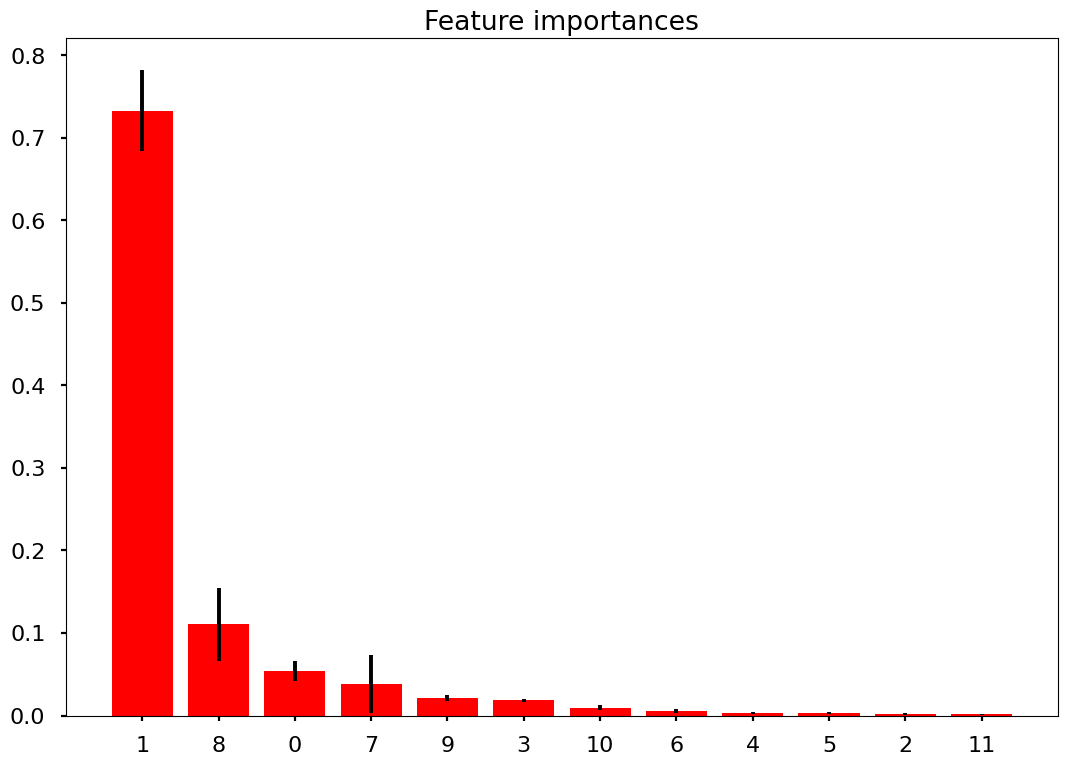

In [254]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [256]:
#Dropping month as it is least important feature

X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

In [260]:
#Running model again without 'month'

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, Y_train)

# predictions on train set
Y_pred = pipe.predict(X1_train)

# predictions on test set
Y_pred_test = pipe.predict(X1_test)

In [262]:
wmae_test(Y_test, Y_pred_test)

4341.767849846648

Better result than before

In [265]:
# Now, I want to make sure that my model will learn from the columns which I dropped or not. So, I will apply my model to whole encoded data again.

# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
Y_train_enc = train_data_enc[target]
Y_test_enc = test_data_enc[target]

In [267]:
X_enc = df_encoded[used_cols1]

In [269]:
X_enc = X_enc.drop(['Date'], axis=1)

In [271]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [273]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, Y_train_enc)

# predictions on train set
Y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
Y_pred_test_enc = pipe.predict(X_test_enc)

In [275]:
wmae_test(Y_test_enc, Y_pred_test_enc)

2527.8371453807604

We found better results for whole data, it means our model can learn from columns which I dropped before.

Feature ranking:
1. feature 1 (0.744048)
2. feature 13 (0.067102)
3. feature 12 (0.052065)
4. feature 0 (0.031637)
5. feature 10 (0.028733)
6. feature 11 (0.015035)
7. feature 18 (0.012780)
8. feature 3 (0.011008)
9. feature 4 (0.009966)
10. feature 19 (0.005065)
11. feature 7 (0.004577)
12. feature 9 (0.003981)
13. feature 5 (0.003667)
14. feature 8 (0.003639)
15. feature 6 (0.002623)
16. feature 2 (0.001102)
17. feature 20 (0.001028)
18. feature 16 (0.000970)
19. feature 17 (0.000606)
20. feature 15 (0.000193)
21. feature 14 (0.000174)


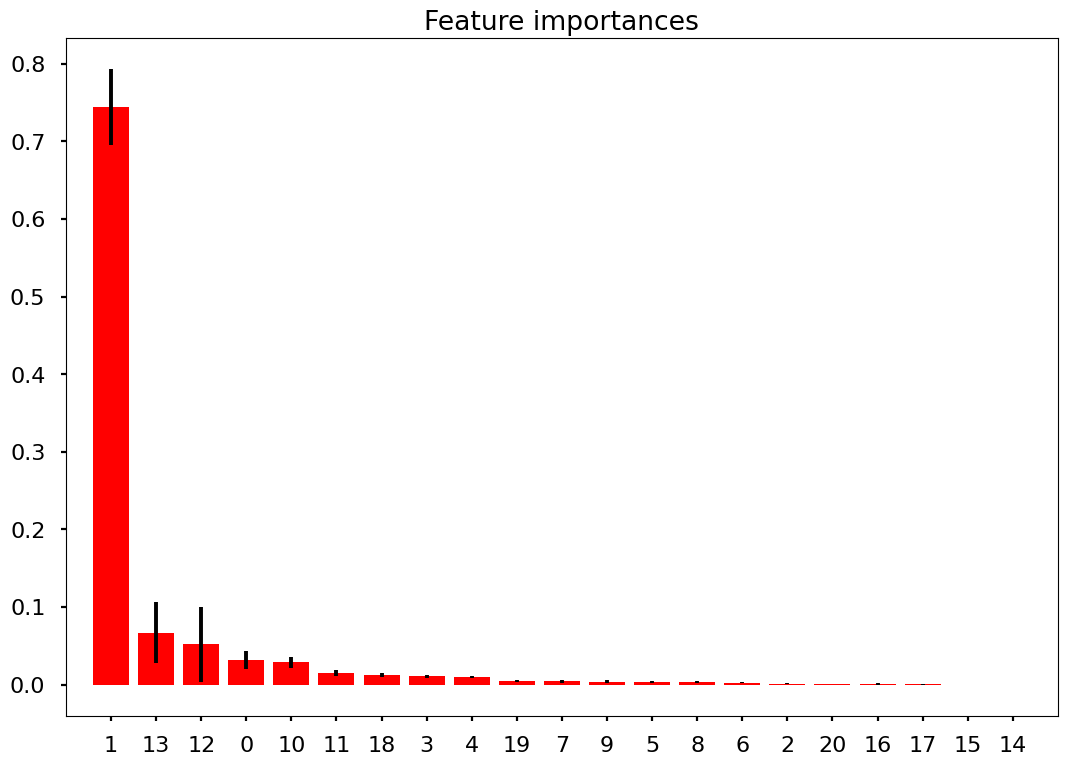

In [278]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

In [282]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_column, axis=1, inplace=True)

In [284]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
Y_train_enc1 = train_data_enc_new[target]
Y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [286]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, Y_train_enc1)

# predictions on train set
Y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
Y_pred_test_enc = pipe.predict(X_test_enc1)

In [290]:
pipe.score(X_test_enc1,Y_test_enc1)

0.7301163967714206

In [294]:
wmae_test(Y_test_enc1, Y_pred_test_enc)

2000.840362122697

Best results with doing feature selection from whole encoded dataset.

In [297]:
#With the same dateset before, I try to model again without month column.
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_column, axis=1, inplace=True)

In [299]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [301]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [303]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
Y_train_enc2 = train_data_enc_new1[target]
Y_test_enc2 = test_data_enc_new1[target]

In [305]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, Y_train_enc2)

# predictions on train set
Y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
Y_pred_test_enc = pipe.predict(X_test_enc2)

In [307]:
pipe.score(X_test_enc2, Y_test_enc2)

0.7151872056567885

In [309]:
wmae_test(Y_test_enc2, Y_pred_test_enc)

2054.609836290659

Not better results than before.

In [312]:
df_results = pd.DataFrame(columns=["Model", "Info",'WMAE']) # result df for showing results together

In [316]:
# writing results to df
df_results = pd.concat([df_results, pd.DataFrame([{
     "Model": 'RandomForestRegressor',
      "Info": 'w/out divided holiday columns',
       'WMAE': 4701
}])], ignore_index=True)

In [320]:
df_results = pd.concat([df_results, pd.DataFrame([{
     "Model": 'RandomForestRegressor' ,
      "Info": 'w/out month column' ,
       'WMAE' : 4341}])], ignore_index=True)
df_results = pd.concat([df_results, pd.DataFrame([{
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data' ,
       'WMAE' : 2527}])], ignore_index=True)
df_results = pd.concat([df_results, pd.DataFrame([{
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data with feature selection' ,
       'WMAE' : 2000}])], ignore_index=True)
df_results = pd.concat([df_results, pd.DataFrame([{
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data with feature selection w/out month' ,
       'WMAE' : 2044}])], ignore_index=True)

In [322]:
df_results

,Model,Info,WMAE
0,RandomForestRegressor,w/out divided holiday columns,4701
1,RandomForestRegressor,w/out month column,4341
2,RandomForestRegressor,whole data,2527
3,RandomForestRegressor,whole data with feature selection,2000
4,RandomForestRegressor,whole data with feature selection w/out month,2044


TIME SERIES MODEL

In [325]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


In [327]:
df['Date'] = pd.to_datetime(df['Date'])

In [329]:
df.set_index('Date', inplace=True) #seting date as index

PLOTTING SALES

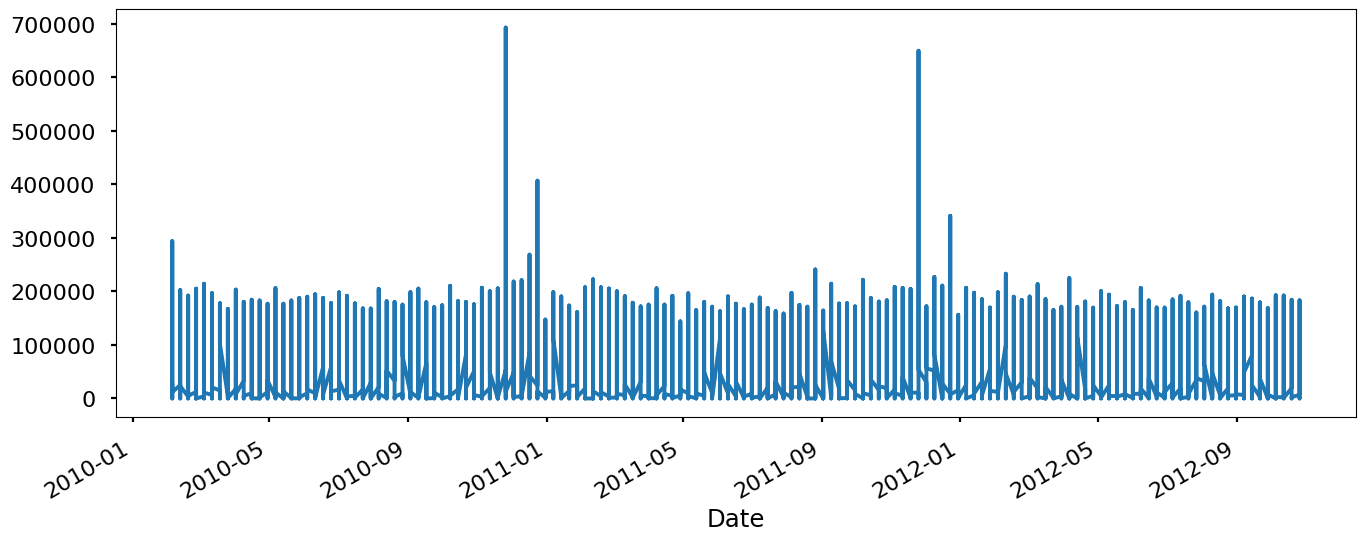

In [332]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, I will collect them together as weekly.

In [347]:
df_week = df.resample('W').mean() #resample data as weekly

In [337]:
print(df.dtypes)

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
Super_Bowl         bool
Labor_Day          bool
Thanksgiving       bool
Christmas          bool
week              int64
month             int64
year              int64
dtype: object


In [339]:
df_week = df.select_dtypes(include=['number']).resample('W').mean()

In [341]:
df = df.apply(pd.to_numeric, errors='coerce')
df_week = df.resample('W').mean()

In [343]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"Column: {col}, Unique Values: {df[col].unique()[:10]}")

In [345]:
df.replace({'AAAAA': np.nan, 'BBBBB': np.nan, 'CCCCC': np.nan}, inplace=True)

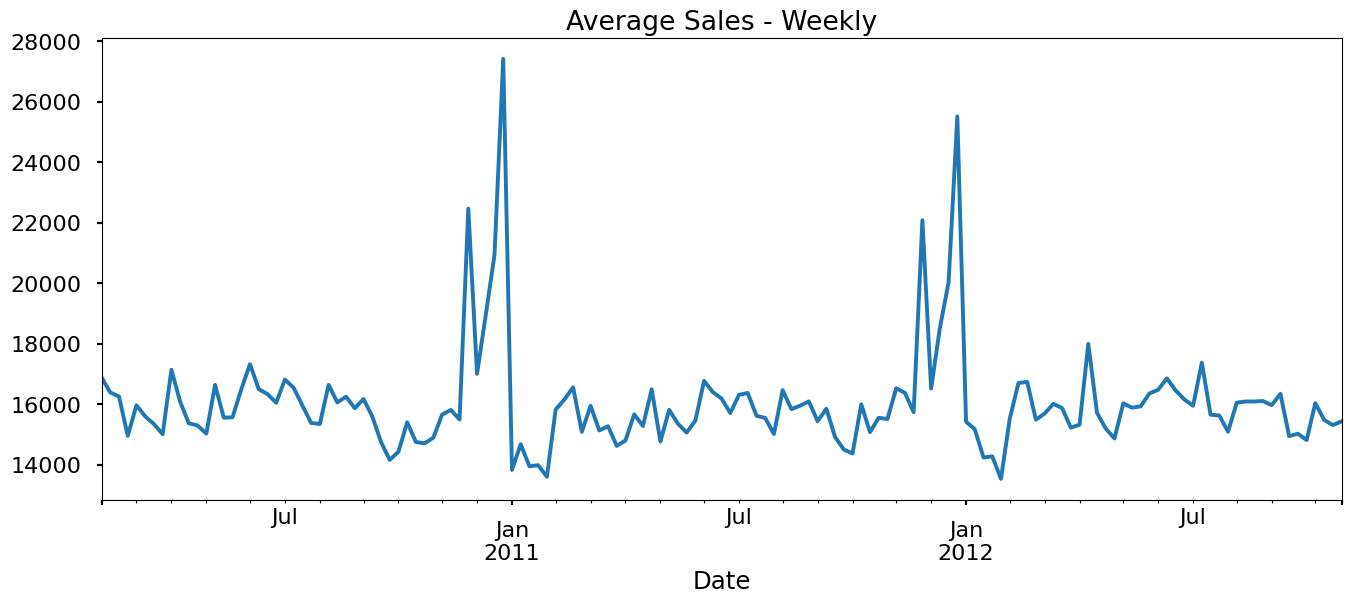

In [349]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [351]:
df_month = df.resample('MS').mean() # resampling as monthly

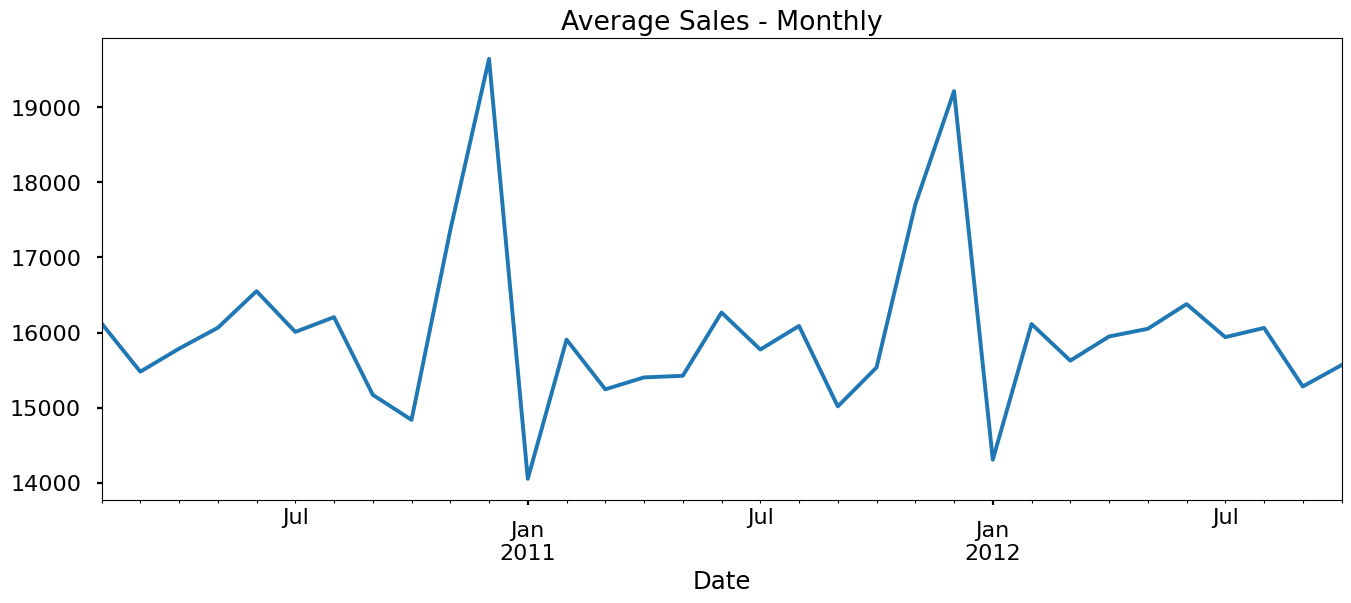

In [353]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

When I turned data to monthly, I realized that I lost some patterns in weekly data. So, I will continue with weekly resampled data.

In [356]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

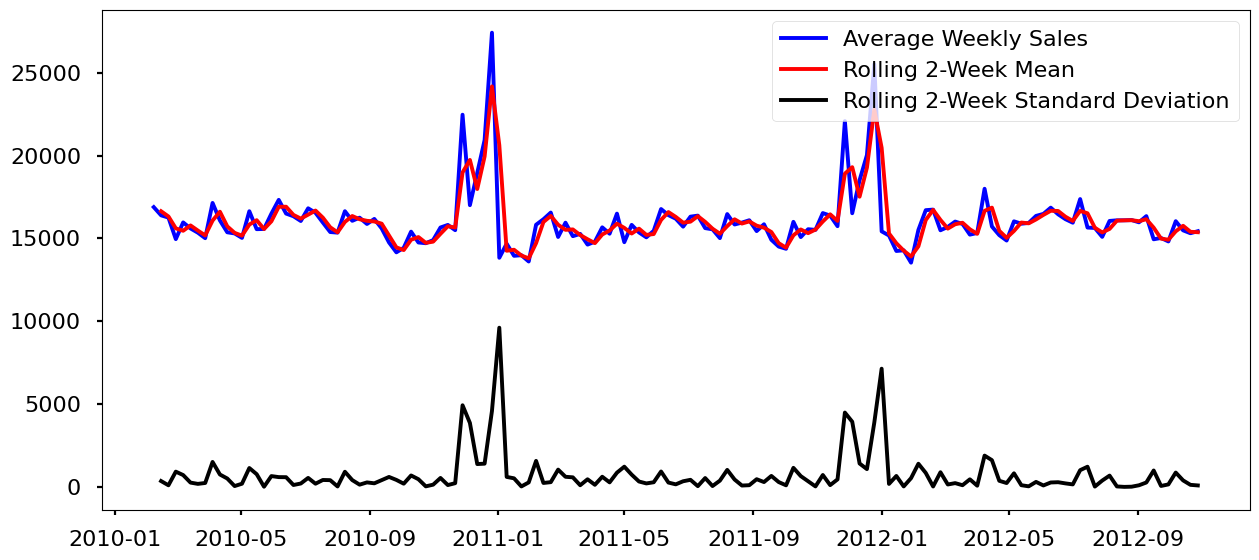

In [358]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

Adfuller Test to Make Sure

In [365]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737566,
 2.4290492082043256e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

In [367]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 22)
Test: (43, 22)


In [369]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
Y_train = train_data[target]
Y_test = test_data[target]

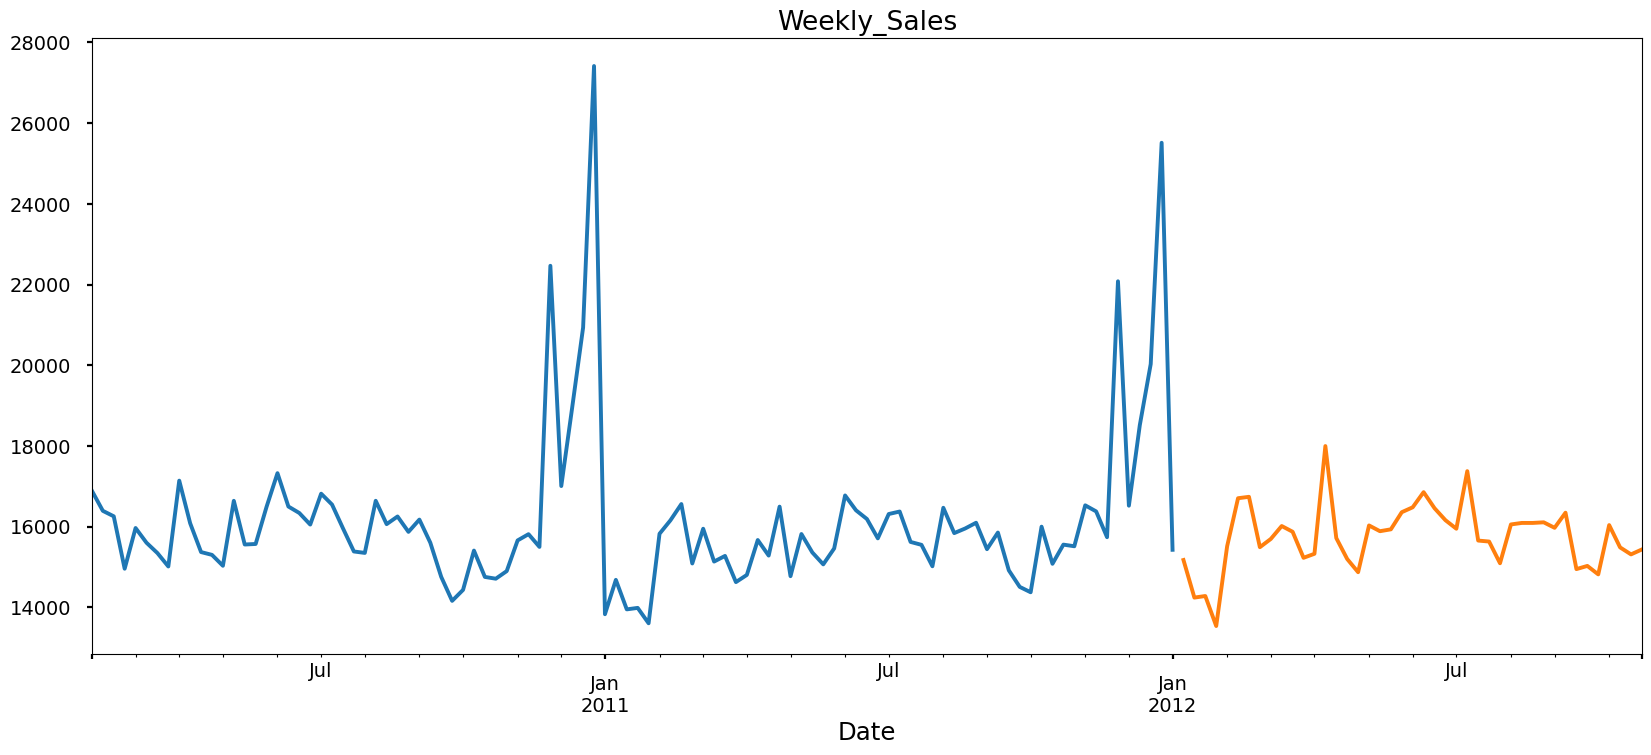

In [371]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, orange is test data.

In [380]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data

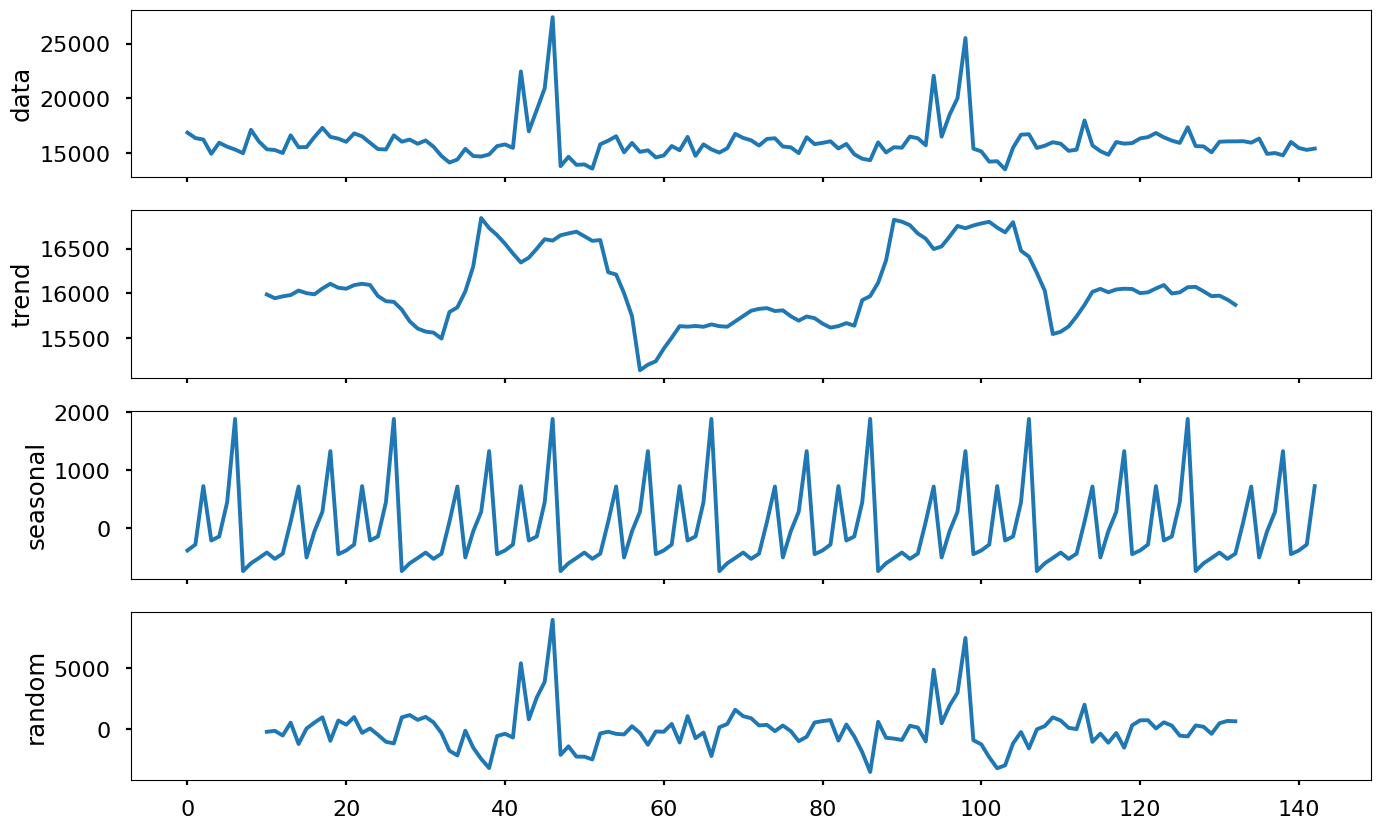

In [382]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model.

In [385]:
# I will try to make my data more stationary. To do this, I will try model with differenced, logged and shifted data.

df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [387]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

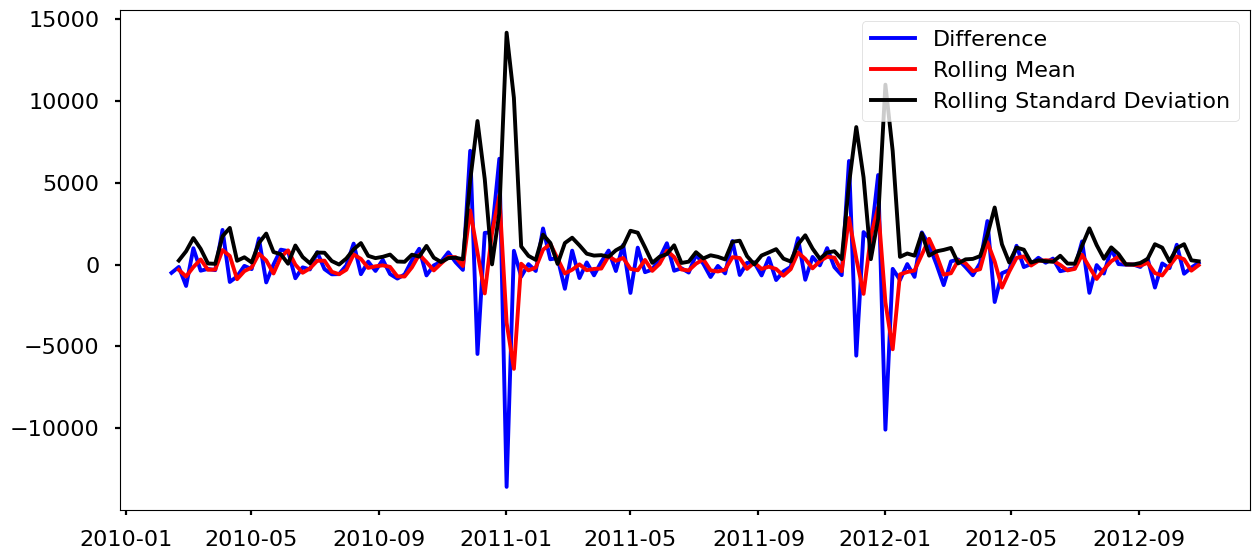

In [389]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

2. SHIFT

In [392]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data

In [394]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

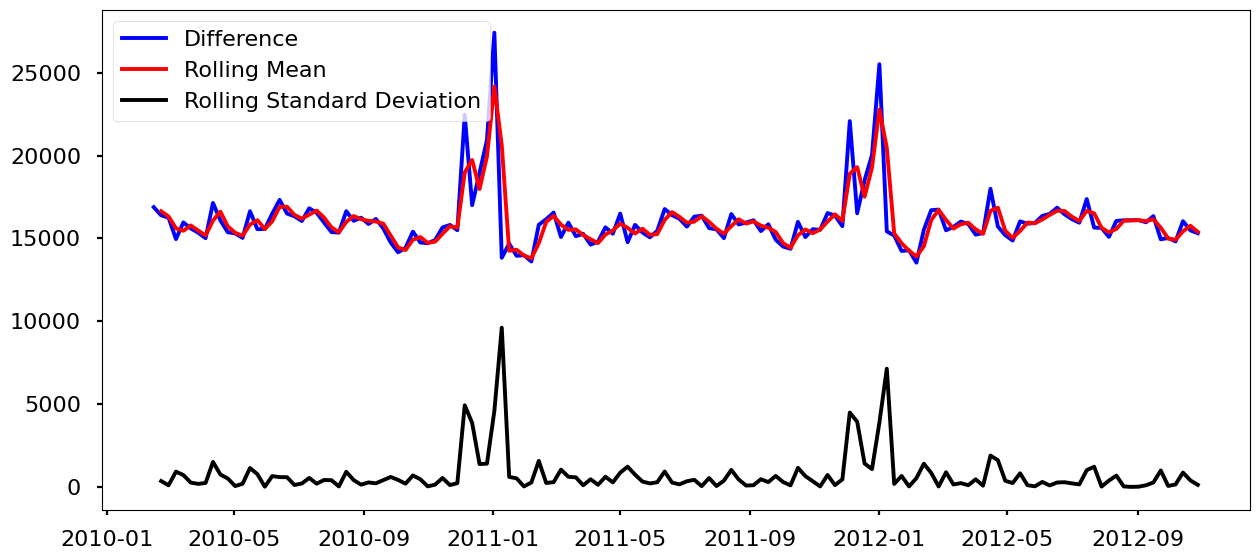

In [396]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

3. LOG

In [399]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [401]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

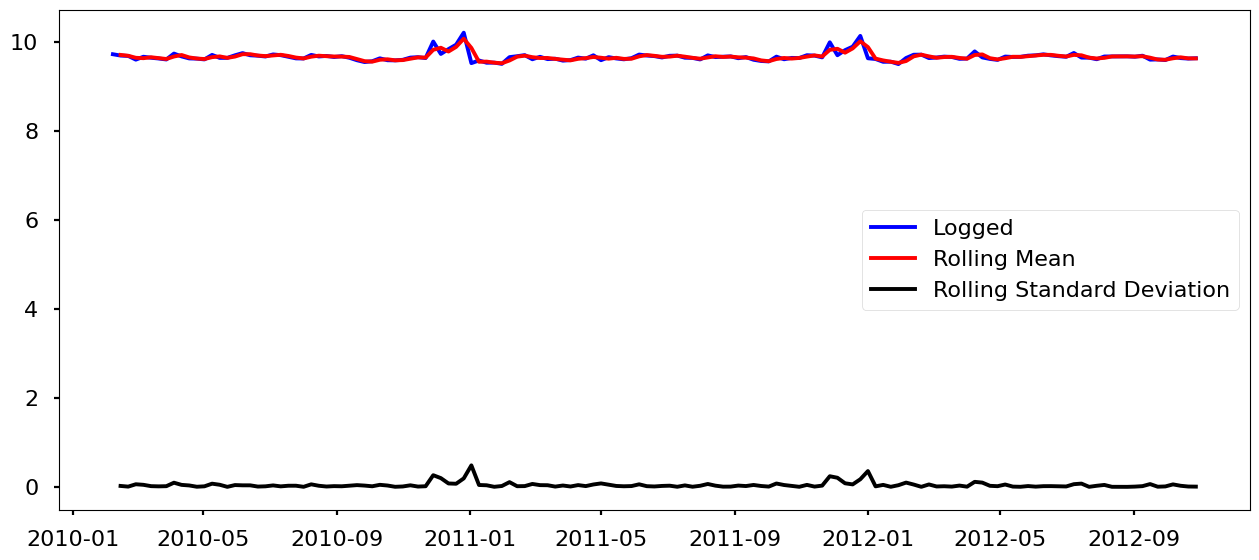

In [403]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

Auto-ARIMA MODEL

I tried my data without any changes, then tried with shifting, taking log and difference version of data. Differenced data gave best results. So, I decided to take difference and use this data.

In [407]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [409]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

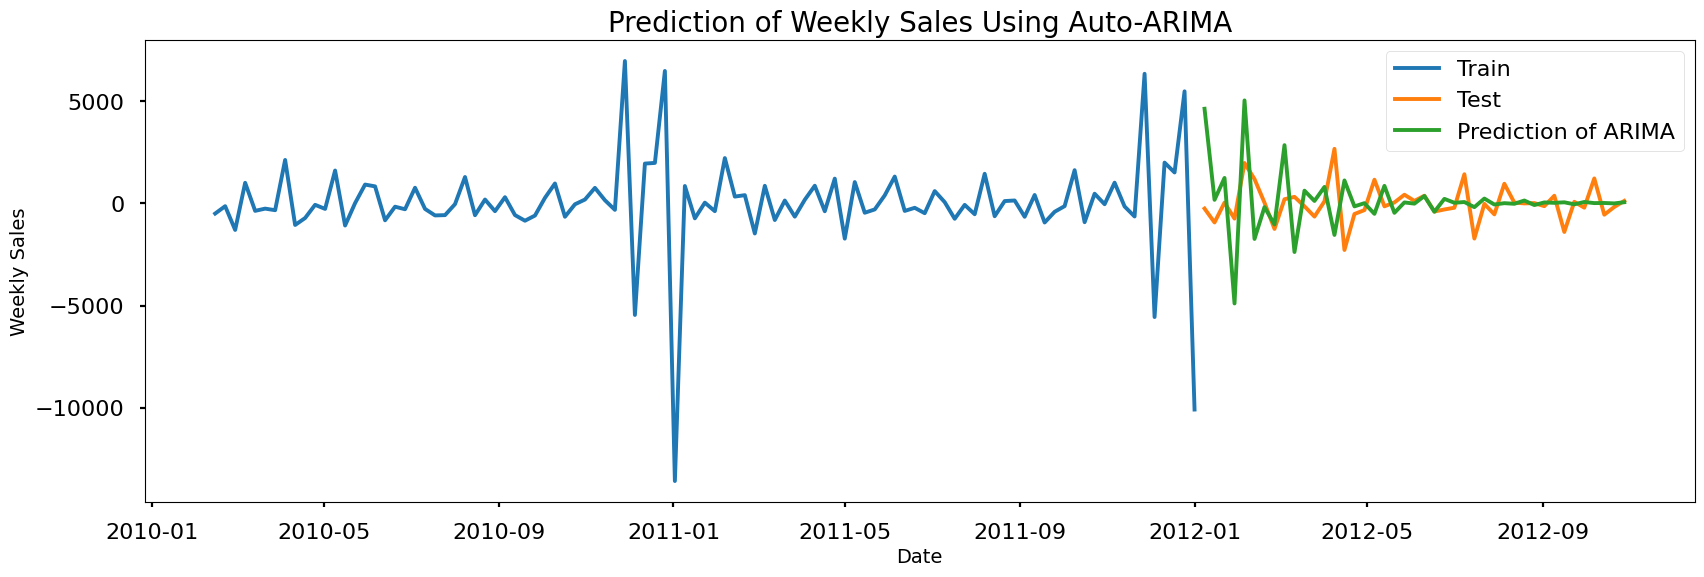

In [432]:
Y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
Y_pred = pd.DataFrame(Y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(Y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

I do not like the pattern of predictions so I decided to try another model.

ExponentialSmoothing

I checked suitable Holt-Winters models according tp my data. Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future.

My difference data has some minus and zero values, so I used additive seasonal and trend instead of multiplicative. Seasonal periods are chosen from the decomposed graphs above. For tuning the model with iterations take too much time so, I changed and tried model for different parameters and found the best parameters and fitted them to model.

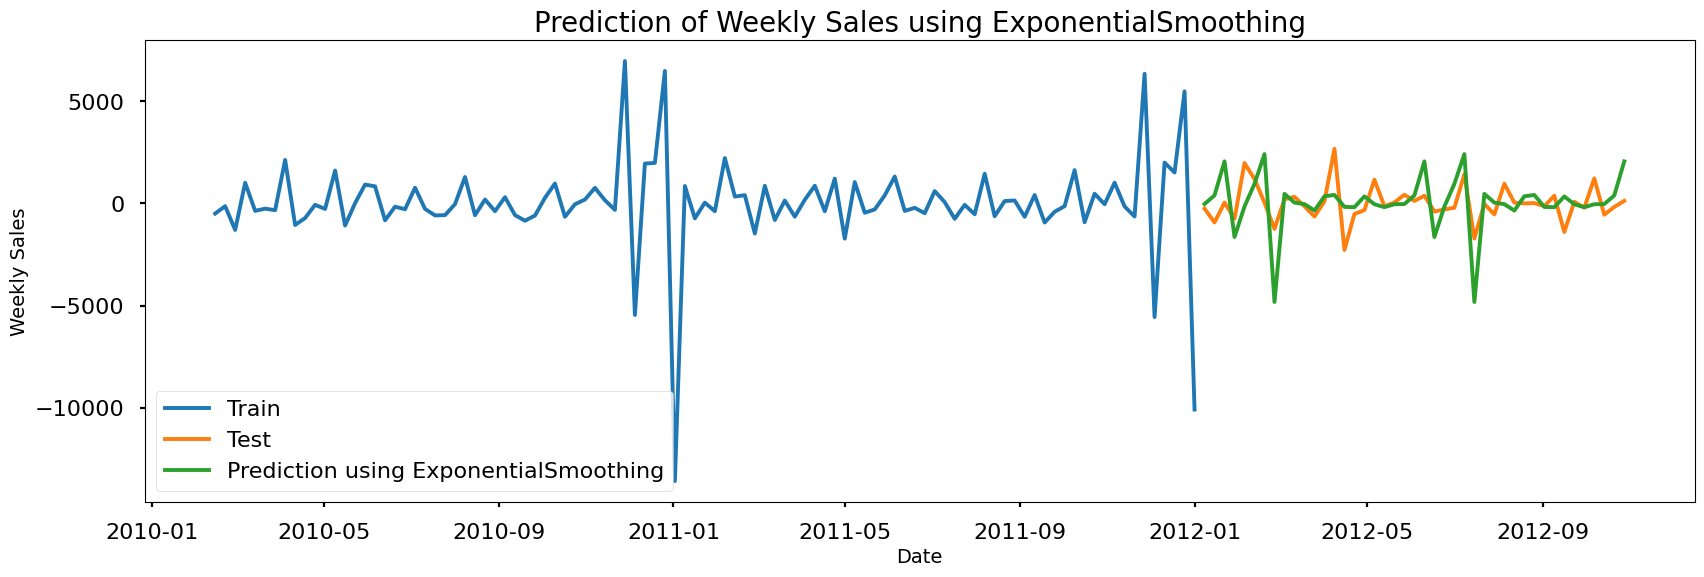

In [437]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
Y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(Y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [439]:
wmae_test(test_data_diff, Y_pred)

840.681060966696

At the end, I found best results for my data with Exponential Smoothing Model.

My best result for this project is 840. According to sales amounts this value is roughly around 5% error. If we can take our average sales and take percentage of 840 errors, it gives 5% roughly.